## Questão 2

##### Esta etapa se baseia na análise dos dados e construção de um modelo para analisarmos a aderência a acordos de clientes que estão com mais de 180 dias de atraso nas suas faturas de cartão de crédito.

In [39]:
## Importando as bibliotecas necessárias

import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
base2_1 = pd.read_csv('.../Questão 2 - Base 1.txt', sep="\t")
base2_2 = pd.read_csv('.../Questão 2 - Base 2.txt', sep="\t")
base2_3 = pd.read_csv('.../Questão 2 - Base 3.txt', sep="\t")
base2_4 = pd.read_csv('.../Questão 2 - Base 4.txt', sep="\t")
base2_5 = pd.read_csv('.../Questão 2 - Base 5.txt', sep="\t")

A base 4 possui uma coluna com um tipo diferente das demais. É preciso fazer uma transformação nela.

In [3]:
base2_4['DT_ACORDO'] = base2_4['DT_ACORDO'].apply(lambda x: x[:10])

Juntando todas em uma só:

In [4]:
base2_resumo = pd.merge(base2_1, base2_2, how='left', on=['ID_CONTA','DT_ACORDO'])
base2_resumo = pd.merge(base2_resumo, base2_3, how='left', on=['ID_CONTA','DT_ACORDO'])
base2_resumo = pd.merge(base2_resumo, base2_4, how='left', on=['ID_CONTA','DT_ACORDO'])
base2_resumo = pd.merge(base2_resumo, base2_5, how='left', on=['ID_CONTA','DT_ACORDO'])
base2_resumo = base2_resumo.drop_duplicates()
base2_resumo.head()

,ID_CONTA,DT_ACORDO,NU_DIAS_ATRASO,VALOR_CRELIQ,DIVIDA_ATUAL,RESPOSTA,QTD_PARCELAMENTO_3M,QTD_PARCELAMENTO_6M,QTD_PARCELAMENTO_12M,LIMITE,...,QTD_CPC_3M,QTD_CPC_6M,QTD_CP_10D,QTD_CP_1M,QTD_CP_3M,QTD_CP_6M,QTD_ACIONAMENTO_10D,QTD_ACIONAMENTO_1M,QTD_ACIONAMENTO_3M,QTD_ACIONAMENTO_6M
0,1194908,2018-11-22,221,324.38,463.73,0,0,0,0,1820.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0
1,1447997,2018-11-22,191,334.82,451.56,1,0,0,0,449.0,...,2.0,4.0,0.0,1.0,2.0,2.0,8.0,11.0,78.0,241.0
2,1035415,2018-11-22,252,1682.26,2554.18,0,0,0,0,1208.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,6.0,16.0
3,1069434,2018-11-22,231,1625.01,2368.65,0,0,0,0,3499.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,1427566,2018-11-22,270,320.07,503.25,0,0,0,0,270.0,...,0.0,0.0,0.0,1.0,1.0,1.0,10.0,13.0,13.0,13.0


Com a junção, alguns valores ficaram nulos. Será preciso substituir os nulos por zero.

In [5]:
print(base2_resumo.isnull().values.any())
print(base2_resumo.isna().values.any())

True
True


In [6]:
base2_resumo = base2_resumo.fillna(0)
print(base2_resumo.isnull().values.any())
print(base2_resumo.isna().values.any())

False
False


Como esse conjunto de dados possui muitas colunas, iremos trabalhar com elas de forma separada. Essa será a ordem:

1. Dias em atraso
2. Valor de dívidas
3. Parcelamentos
4. Faturas emitidas
5. Ligações

## Dias em atraso

A variável de interesse é 'RESPOSTA', em que 0 significa que o cliente não aderiu ao acordo e 1 caso contrário. O percentual de adesão aos acordos é de aproximadamente 3%.

In [10]:
print("% de adesão: ", round(len(base2_resumo[base2_resumo.RESPOSTA == 1])/len(base2_resumo) *100, 2))
print("% de não adesão: ",round(len(base2_resumo[base2_resumo.RESPOSTA == 0])/len(base2_resumo) *100, 2))

% de adesão:  2.96
% de não adesão:  97.04


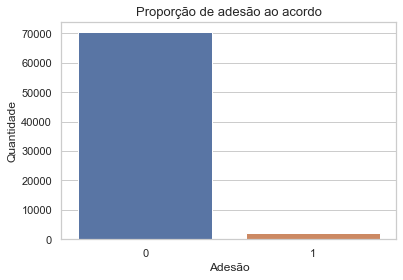

In [184]:
sns.set_theme(style="whitegrid")
sns.countplot(x='RESPOSTA',data=base2_resumo)
plt.title("Proporção de adesão ao acordo", fontdict={'fontsize':13})
plt.xlabel('Adesão')
plt.ylabel('Quantidade')
plt.show()

In [180]:
base2_resumo['NU_DIAS_ATRASO'].describe()

count    72532.000000
mean       326.611372
std         97.164631
min        181.000000
25%        245.000000
50%        311.000000
75%        400.000000
max        540.000000
Name: NU_DIAS_ATRASO, dtype: float64

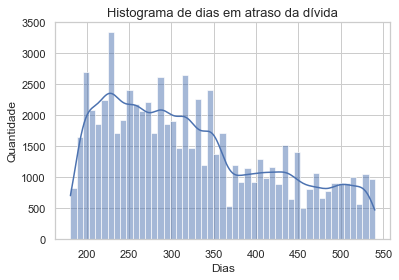

In [188]:
sns.histplot(x='NU_DIAS_ATRASO', data = base2_resumo, kde=True)
plt.title("Histograma de dias em atraso da dívida", fontdict={'fontsize':13})
plt.xlabel('Dias')
plt.ylabel('Quantidade')
plt.show()

É possível notar que a maior concentração das faturas em dívida está nos primeiros dias de cobrança. Após 350 dias esse número diminui, mas ainda em grandes quantidades.

### % de adesão mensal por faixa de atraso

In [168]:
base_dias = base2_resumo[['ID_CONTA','DT_ACORDO','NU_DIAS_ATRASO','RESPOSTA']]

In [169]:
## Criando uma base para calcular o percentual por mês

base_dias.DT_ACORDO = base_dias.DT_ACORDO.apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))

dias = []

for i in base_dias.NU_DIAS_ATRASO:
    dias.append(timedelta(days=int(i)))
    
base_dias["dias"] = dias
base_dias['DT_DIVIDA'] = base_dias.DT_ACORDO - base_dias.dias
base_dias['meses'] = ((base_dias.DT_ACORDO - base_dias.DT_DIVIDA)/np.timedelta64(1 , 'M')).astype(int)
base_dias.meses.replace(5,6, inplace = True)

In [170]:
base_dias_0 = base_dias[base_dias.RESPOSTA == 0]
base_dias_1 = base_dias[base_dias.RESPOSTA == 1]

base_dias_0 = base_dias_0.groupby(['meses']).count()
base_dias_0 = base_dias_0.add_suffix('').reset_index()
base_dias_0 = base_dias_0[['meses','ID_CONTA']]
base_dias_0.rename(columns={'ID_CONTA': 'QTD_0'}, inplace = True)

base_dias_1 = base_dias_1.groupby(['meses']).count()
base_dias_1 = base_dias_1.add_suffix('').reset_index()
base_dias_1 = base_dias_1[['meses','ID_CONTA']]
base_dias_1.rename(columns={'ID_CONTA': 'QTD_1'}, inplace = True)

bd_meses = pd.merge(base_dias_0, base_dias_1, how='left', on='meses')
bd_meses['PERCENT'] = round(bd_meses.QTD_1/(bd_meses.QTD_0+bd_meses.QTD_1)*100,2)

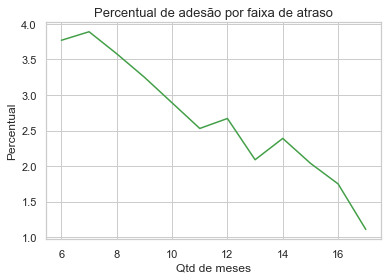

In [186]:
plt.plot('meses','PERCENT', data = bd_meses, color = "#439F48")
plt.title("Percentual de adesão por faixa de atraso", fontdict={'fontsize':13})
plt.xlabel('Qtd de meses')
plt.ylabel('Percentual')
plt.show()

Nos primeiros meses do acordo, após 180 dias do atraso da fatura, a taxa de adesão atinge 3,89%. Quanto mais o tempo passa, menor é a chance de o cliente aderir ao acordo, pois a taxa decresce atingindo 1,11% com 17 meses.

## Valor de dívidas

In [202]:
base2_resumo[['NU_DIAS_ATRASO','VALOR_CRELIQ','DIVIDA_ATUAL','LIMITE']].corr()

,NU_DIAS_ATRASO,VALOR_CRELIQ,DIVIDA_ATUAL,LIMITE
NU_DIAS_ATRASO,1.000000,0.171923,0.390775,0.149175
VALOR_CRELIQ,0.171923,1.000000,0.955451,0.793582
DIVIDA_ATUAL,0.390775,0.955451,1.000000,0.751625
LIMITE,0.149175,0.793582,0.751625,1.000000


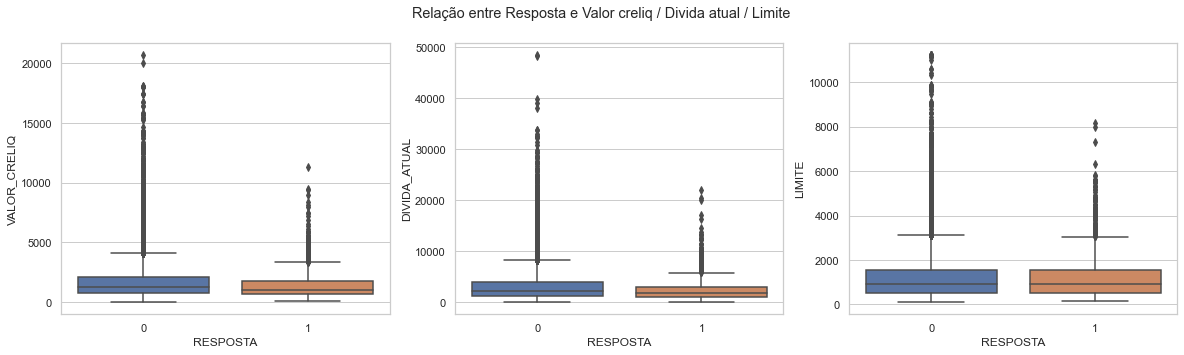

In [201]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=False)
fig.suptitle('Relação entre Resposta e Valor creliq / Divida atual / Limite', fontdict={'fontsize':13})

sns.boxplot(y='VALOR_CRELIQ', x='RESPOSTA', data = base2_resumo, ax=axes[0])
sns.boxplot(y='DIVIDA_ATUAL', x='RESPOSTA', data = base2_resumo, ax=axes[1])
sns.boxplot(y='LIMITE', x='RESPOSTA', data = base2_resumo, ax=axes[2])

plt.show()

Verificando as variáveis VALOR_CRELIQ que é o valor da dívida quando se ultrapassa 65 dias e DIVIDA_ATUAL que é a dívida atualizada com juros e LIMITE, é possível notar uma alta correlação entre as primeiras (0,95). Assim sendo, as duas agem da mesma forma na variável resposta, como é notada pelo boxplot. Pelo limite também não vemos diferença entre a adesão de acordo.

Não parece haver uma diferença entre o valor da dívida ou o valor em creliq pela adesão aos acordos. Só é possível notar que os valores mais altos não possuem acordos.

## Parcelamentos

In [211]:
base2_resumo[['QTD_PARCELAMENTO_3M','QTD_PARCELAMENTO_6M','QTD_PARCELAMENTO_12M']].describe()

,QTD_PARCELAMENTO_3M,QTD_PARCELAMENTO_6M,QTD_PARCELAMENTO_12M
count,72532.000000,72532.000000,72532.000000
mean,0.343586,0.486323,0.612792
std,0.564863,0.716000,0.892865
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,3.000000,4.000000,6.000000


In [203]:
base2_resumo[['QTD_PARCELAMENTO_3M','QTD_PARCELAMENTO_6M','QTD_PARCELAMENTO_12M']].corr()

,QTD_PARCELAMENTO_3M,QTD_PARCELAMENTO_6M,QTD_PARCELAMENTO_12M
QTD_PARCELAMENTO_3M,1.000000,0.860123,0.757683
QTD_PARCELAMENTO_6M,0.860123,1.000000,0.904245
QTD_PARCELAMENTO_12M,0.757683,0.904245,1.000000


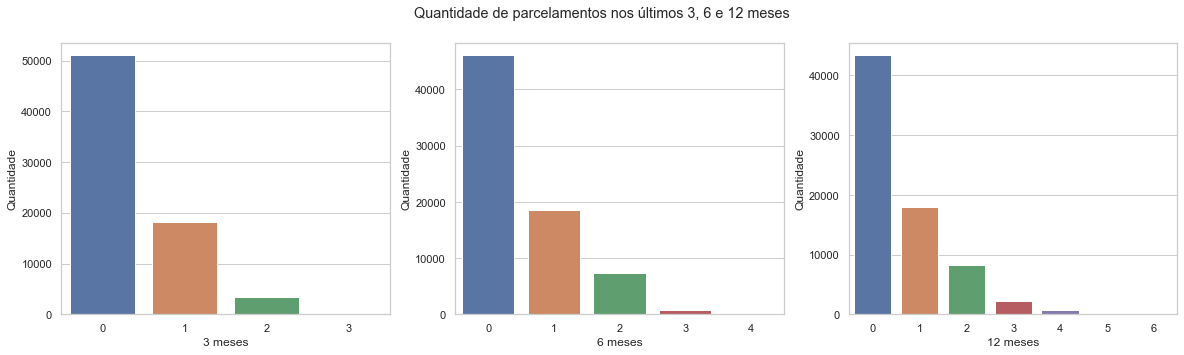

In [210]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=False)
fig.suptitle('Quantidade de parcelamentos nos últimos 3, 6 e 12 meses', fontdict={'fontsize':15})

sns.countplot(x='QTD_PARCELAMENTO_3M', data = base2_resumo, ax=axes[0])
axes[0].set_xlabel('3 meses')
axes[0].set_ylabel('Quantidade')
sns.countplot(x='QTD_PARCELAMENTO_6M', data = base2_resumo, ax=axes[1])
axes[1].set_xlabel('6 meses')
axes[1].set_ylabel('Quantidade')
sns.countplot(x='QTD_PARCELAMENTO_12M', data = base2_resumo, ax=axes[2])
axes[2].set_xlabel('12 meses')
axes[2].set_ylabel('Quantidade')
plt.show()

É possivel notar que 50% dos clientes não possuem parcelamento de faturas antes da fatura com dívida. O maior número de parcelas é 6 se observarmos o histórico dos últimos 12 meses. E também não diferem na relação com a variável resposta.

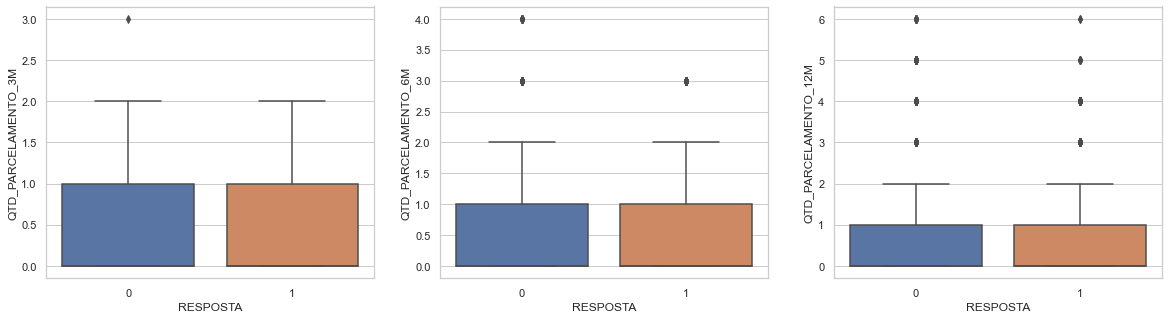

In [214]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=False)

sns.boxplot(y='QTD_PARCELAMENTO_3M', x='RESPOSTA', data = base2_resumo, ax=axes[0])
sns.boxplot(y='QTD_PARCELAMENTO_6M', x='RESPOSTA', data = base2_resumo, ax=axes[1])
sns.boxplot(y='QTD_PARCELAMENTO_12M', x='RESPOSTA', data = base2_resumo, ax=axes[2])
plt.show()

In [228]:
base_parc_0 = base2_resumo[base2_resumo.RESPOSTA == 0]
base_parc_1 = base2_resumo[base2_resumo.RESPOSTA == 1]

base_parc_0 = base_parc_0.groupby(['QTD_PARCELAMENTO_6M']).count()
base_parc_0 = base_parc_0.add_suffix('').reset_index()
base_parc_0 = base_parc_0[['QTD_PARCELAMENTO_6M','ID_CONTA']]
base_parc_0.rename(columns={'ID_CONTA': 'QTD_0'}, inplace = True)

base_parc_1 = base_parc_1.groupby(['QTD_PARCELAMENTO_6M']).count()
base_parc_1 = base_parc_1.add_suffix('').reset_index()
base_parc_1 = base_parc_1[['QTD_PARCELAMENTO_6M','ID_CONTA']]
base_parc_1.rename(columns={'ID_CONTA': 'QTD_1'}, inplace = True)

bd_parc = pd.merge(base_parc_0, base_parc_1, how='left', on='QTD_PARCELAMENTO_6M')
bd_parc['PERCENT'] = round(bd_parc.QTD_1/(bd_parc.QTD_0+bd_parc.QTD_1)*100,2)
bd_parc = bd_parc.fillna(0)

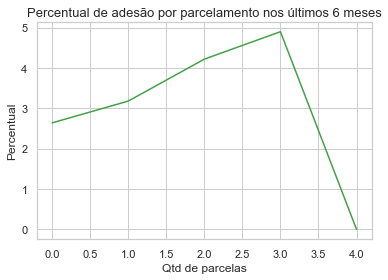

In [232]:
plt.plot('QTD_PARCELAMENTO_6M','PERCENT', data = bd_parc, color = "#439F48")
plt.title("Percentual de adesão por parcelamento nos últimos 6 meses", fontdict={'fontsize':13})
plt.xlabel('Qtd de parcelas')
plt.ylabel('Percentual')
plt.show()

Verificando os últimos 6 meses dos clientes, nota-se um crescimento da taxa de adesão, de 2,64% para quem não tem parcelamento de fatura até 4,9% para quem tem 3 parcelas.

## Faturas emitidas

## Ligações

In [234]:
base2_resumo[['QTD_CPC_10D','QTD_CPC_1M','QTD_CPC_3M','QTD_CPC_6M','QTD_CP_10D','QTD_CP_1M','QTD_CP_3M','QTD_CP_6M','QTD_ACIONAMENTO_10D','QTD_ACIONAMENTO_1M','QTD_ACIONAMENTO_3M','QTD_ACIONAMENTO_6M']].describe()

,QTD_CPC_10D,QTD_CPC_1M,QTD_CPC_3M,QTD_CPC_6M,QTD_CP_10D,QTD_CP_1M,QTD_CP_3M,QTD_CP_6M,QTD_ACIONAMENTO_10D,QTD_ACIONAMENTO_1M,QTD_ACIONAMENTO_3M,QTD_ACIONAMENTO_6M
count,72532.000000,72532.000000,72532.000000,72532.000000,72532.000000,72532.000000,72532.000000,72532.000000,72532.000000,72532.000000,72532.000000,72532.000000
mean,0.006452,0.032455,0.166313,0.391041,0.063282,0.226190,0.822699,1.635843,3.074698,12.334832,46.126579,97.818728
std,0.084589,0.191778,0.509993,0.968232,0.301003,0.641274,1.558579,2.776591,4.520159,14.342847,52.163316,97.789358
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,17.000000,35.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,8.000000,31.000000,72.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,4.000000,16.000000,60.000000,134.000000
max,5.000000,5.000000,10.000000,15.000000,7.000000,10.000000,25.000000,39.000000,140.000000,553.000000,3022.000000,4760.000000


Pelas descritivas acima é possível observar que a maioria dos clientes não atendem as ligações, nem mesmo sendo recado (outra pessoa atende). Até os 6 primeiros meses de cobrança, 75% não atenderam 1 ligação e quando é recado 75% atendem 2 vezes, sendo que a quantidade de ligações feitas nos primeiros 10 dias é, em média, de 3 ligações.

Vamos observar a adesão quando o cliente atende a ligação.

In [237]:
CPC_6M = base2_resumo[base2_resumo.QTD_CPC_6M != 0]
CPC_3M = base2_resumo[base2_resumo.QTD_CPC_3M != 0]
CPC_1M = base2_resumo[base2_resumo.QTD_CPC_1M != 0]
CPC_10D = base2_resumo[base2_resumo.QTD_CPC_10D != 0]

In [236]:
print("Quando o cliente atende a ligação, a taxa de adesão ao acordo por período é de:")
print("Primeiros 10 dias: ", round(CPC_10D.RESPOSTA.sum()/CPC_10D.RESPOSTA.count() *100,2))
print("Primeiro mês: ", round(CPC_1M.RESPOSTA.sum()/CPC_1M.RESPOSTA.count() *100,2))
print("Primeiros 3 meses: ", round(CPC_3M.RESPOSTA.sum()/CPC_3M.RESPOSTA.count() *100,2))
print("Primeiros 6 meses: ", round(CPC_6M.RESPOSTA.sum()/CPC_6M.RESPOSTA.count() *100,2))

Quando o cliente atende a ligação, a taxa de adesão ao acordo por período é de:
Primeiros 10 dias:  7.8
Primeiro mês:  5.65
Primeiros 3 meses:  4.53
Primeiros 6 meses:  4.59


Podemos ver que quanto menor é o tempo entre a inadimplência e os acionamentos, maior é a chance do cliente fazer o acordo. No entanto, a frequencia de ligação nesse período é baixa, cerca de 3 ligações nos primeiros 10 dias e 12 ligações no primeiro mês. Uma ideia é aumentar o número de ligações no período inicial e reduzir ao passar de 3 meses, pois a taxa não varia de forma significativa (de 4,53 para 4,59).

Agora vamos observar as ligações quando um terceiro atende.

In [238]:
CP_6M = base2_resumo[base2_resumo.QTD_CP_6M != 0]
CP_3M = base2_resumo[base2_resumo.QTD_CP_3M != 0]
CP_1M = base2_resumo[base2_resumo.QTD_CP_1M != 0]
CP_10D = base2_resumo[base2_resumo.QTD_CP_10D != 0]

In [239]:
print("Quando um terceiro atende a ligação, a taxa de adesão ao acordo por período é de:")
print("Primeiros 10 dias: ", round(CP_10D.RESPOSTA.sum()/CP_10D.RESPOSTA.count() *100,2))
print("Primeiro mês: ", round(CP_1M.RESPOSTA.sum()/CP_1M.RESPOSTA.count() *100,2))
print("Primeiros 3 meses: ", round(CP_3M.RESPOSTA.sum()/CP_3M.RESPOSTA.count() *100,2))
print("Primeiros 6 meses: ", round(CP_6M.RESPOSTA.sum()/CP_6M.RESPOSTA.count() *100,2))

Quando um terceiro atende a ligação, a taxa de adesão ao acordo por período é de:
Primeiros 10 dias:  3.51
Primeiro mês:  3.29
Primeiros 3 meses:  2.98
Primeiros 6 meses:  3.03


Não parece haver uma diferença entre o período da ligação com a adesão, mas ainda há a taxa de 3,2% em média.

## Modelagem

Como são 30 variáveis no conjunto de dados, testei selecionar algumas com alguns métodos de seleção, mas os resultados se mostraram mais baixos do que com todas as variáveis no modelo. Portanto apenas ID_CONTA e DT_ACORDO serão retirados no conjunto final.

In [244]:
x = base2_resumo.drop(['ID_CONTA','DT_ACORDO','RESPOSTA'], axis=1)
y = base2_resumo.RESPOSTA

Relembrando que o percentual de adesão geral é de 3% e testando a modelagem com esse percentual, foi visto que nenhum dos modelos que serão apresentados conseguiu se ajustar a essa proporção da base. Portanto será feito um ajuste na proporção da variável resposta com um método de undersampling para classes desbalanceadas.

Esse método consiste em reduzir, de forma aleatória, os eventos da classe predominante. No nosso caso essa classe é o 0 (não adesão ao acordo).

In [245]:
from imblearn.under_sampling import NearMiss
# Iguala as quantidade de amostras entre as classes
eq = NearMiss()

X, y = eq.fit_resample(x,y)

Agora podemos separar as bases em treino e teste para a classificação.

In [246]:
from sklearn.model_selection import train_test_split

In [247]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, random_state=0, test_size = 0.3)

Os modelos a serem testados serão Regressão Logística, SVM, KNN, e Random Forest por serem muito utilizados em problemas de classificação.

In [248]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [251]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [252]:
mod1 = LogisticRegression(max_iter=10000).fit(x_treino,y_treino)

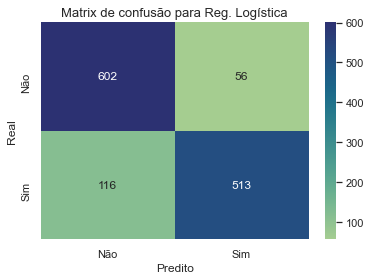

In [281]:
cm1 = confusion_matrix(y_teste, mod1.predict(x_teste))
sns.heatmap(cm1,annot=True,fmt="d", cmap = 'crest', xticklabels=['Não','Sim'], yticklabels=['Não','Sim'])
plt.title("Matrix de confusão para Reg. Logística", fontdict={'fontsize':13})
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

In [263]:
print(classification_report(y_teste, mod1.predict(x_teste)))

              precision    recall  f1-score   support

           0       0.84      0.91      0.88       658
           1       0.90      0.82      0.86       629

    accuracy                           0.87      1287
   macro avg       0.87      0.87      0.87      1287
weighted avg       0.87      0.87      0.87      1287



In [278]:
mod2 = svm.SVC(probability=True).fit(x_treino,y_treino)

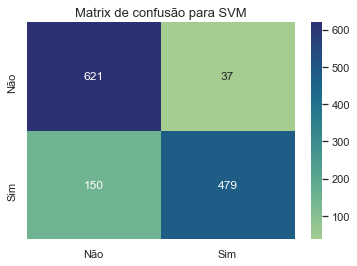

In [279]:
cm2= confusion_matrix(y_teste, mod2.predict(x_teste))
sns.heatmap(cm2,annot=True,fmt="d", cmap = 'crest', xticklabels=['Não','Sim'], yticklabels=['Não','Sim'])
plt.title("Matrix de confusão para SVM", fontdict={'fontsize':13})
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

In [266]:
print(classification_report(y_teste, mod2.predict(x_teste)))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       658
           1       0.93      0.76      0.84       629

    accuracy                           0.85      1287
   macro avg       0.87      0.85      0.85      1287
weighted avg       0.87      0.85      0.85      1287



In [267]:
mod3 = KNeighborsClassifier().fit(x_treino, y_treino)

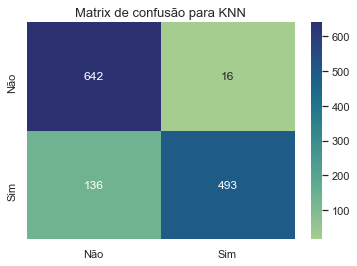

In [268]:
cm3 = confusion_matrix(y_teste, mod3.predict(x_teste))
sns.heatmap(cm3,annot=True,fmt="d", cmap = 'crest', xticklabels=['Não','Sim'], yticklabels=['Não','Sim'])
plt.title("Matrix de confusão para KNN", fontdict={'fontsize':13})
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

In [269]:
print(classification_report(y_teste, mod3.predict(x_teste)))

              precision    recall  f1-score   support

           0       0.83      0.98      0.89       658
           1       0.97      0.78      0.87       629

    accuracy                           0.88      1287
   macro avg       0.90      0.88      0.88      1287
weighted avg       0.90      0.88      0.88      1287



In [270]:
mod4 = RandomForestClassifier().fit(x_treino, y_treino)

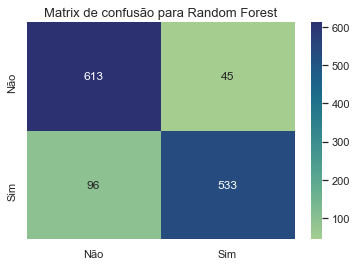

In [271]:
cm4 = confusion_matrix(y_teste, mod4.predict(x_teste))
sns.heatmap(cm4,annot=True,fmt="d", cmap = 'crest', xticklabels=['Não','Sim'], yticklabels=['Não','Sim'])
plt.title("Matrix de confusão para Random Forest", fontdict={'fontsize':13})
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

Para avaliar a performance do modelo foi utilizado a acurácia, precisão, recall e f1-score.

In [311]:
dic1 = classification_report(y_teste, mod1.predict(x_teste), output_dict=True)
dic2 = classification_report(y_teste, mod2.predict(x_teste), output_dict=True)
dic3 = classification_report(y_teste, mod3.predict(x_teste), output_dict=True)
dic4 = classification_report(y_teste, mod4.predict(x_teste), output_dict=True)

In [310]:
ind = ['Reg. Logística','SVM','KNN','Random Forest']
dic_geral = {'Acurácia':[dic1['accuracy'], dic2['accuracy'],dic3['accuracy'],dic4['accuracy']],
             'Precisão':[dic1['1']['precision'],dic2['1']['precision'],dic3['1']['precision'],dic4['1']['precision']],
             'Recall':[dic1['1']['recall'],dic2['1']['recall'],dic3['1']['recall'],dic4['1']['recall']],
             'F1-Score':[dic1['1']['f1-score'],dic2['1']['f1-score'],dic3['1']['f1-score'],dic4['1']['f1-score']]
            }
print(pd.DataFrame(data=dic_geral, index=ind))

                Acurácia  Precisão    Recall  F1-Score
Reg. Logística  0.866356  0.901582  0.815580  0.856427
SVM             0.854701  0.928295  0.761526  0.836681
KNN             0.881896  0.968566  0.783784  0.866432
Random Forest   0.890443  0.922145  0.847377  0.883181


Avaliando as métricas acima podemos utilizar o Random Forest para a previsão da adesão de acordos, pois é o que apresenta a maior acurácia (89%) significando que é um modelo que prevê melhor com relação aos demais e tem o maior recall, que é a habilidade de "acertar" o cliente que vai aderir o acordo.

Avaliando a curva ROC, também nota-se que o Random Forest possui uma área maior e tem um melhor ponto de ótimo da curva.

In [312]:
# AUC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [313]:
# Estimando as probabilidades
log_prob = mod1.predict_proba(x_teste)
probs = log_prob[:, 1]
rfp, rvp, lim = roc_curve(y_teste, probs)

svm_prob = mod2.predict_proba(x_teste)
probs2 = svm_prob[:, 1]
rfp2, rvp2, lim2 = roc_curve(y_teste, probs2)

knn_prob = mod3.predict_proba(x_teste)
probs3 = knn_prob[:, 1]
rfp3, rvp3, lim3 = roc_curve(y_teste, probs3)

rf_prob = mod4.predict_proba(x_teste)
probs4 = rf_prob[:, 1]
rfp4, rvp4, lim4 = roc_curve(y_teste, probs4)

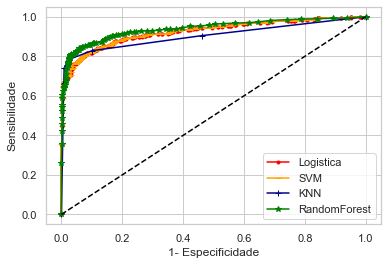

In [317]:
# Gráfico da curva roc
plt.figure()
plt.plot(rfp, rvp, marker='.', label='Logistica',color="red")
plt.plot(rfp, rvp, marker='_', label='SVM',color="orange")
plt.plot(rfp3, rvp3, marker='+', label='KNN',color="darkblue")
plt.plot(rfp4, rvp4, marker='*', label='RandomForest',color="green")
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.xlabel('1- Especificidade')
plt.ylabel('Sensibilidade')

plt.legend()

plt.show()